In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization, Layer
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Verify TensorFlow version
print("TensorFlow Version:", tf.__version__)

# Check available memory (Colab-specific)
!free -h

TensorFlow Version: 2.18.0
               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.2Gi       6.8Gi       1.0Mi       4.7Gi        11Gi
Swap:             0B          0B          0B


In [2]:
# Import Colab's file upload module
from google.colab import files

# Prompt to upload files
uploaded = files.upload()

# Verify uploaded files
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

Saving RUL_FD001.txt to RUL_FD001.txt
Uploaded file: RUL_FD001.txt


In [3]:
# Import Colab's file upload module
from google.colab import files

# Prompt to upload files
uploaded = files.upload()

# Verify uploaded files
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

Saving test_FD001.txt to test_FD001.txt
Uploaded file: test_FD001.txt


In [4]:
# Import Colab's file upload module
from google.colab import files

# Prompt to upload files
uploaded = files.upload()

# Verify uploaded files
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

Saving train_FD001.txt to train_FD001.txt
Uploaded file: train_FD001.txt


In [5]:
# Define column names for CMAPSS FD001 dataset
column_names = ['unit', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2',
                'operational_setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4',
                'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
                'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16',
                'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']

# Read data
fd1_train = pd.read_csv('train_FD001.txt', sep=r'\s+', header=None, names=column_names, engine='python')
fd1_test = pd.read_csv('test_FD001.txt', sep=r'\s+', header=None, names=column_names, engine='python')
rul1 = pd.read_csv('RUL_FD001.txt', sep=r'\s+', header=None, names=['RUL'], usecols=[0])

# Display data shapes
print("Training Data Shape:", fd1_train.shape)
print("Test Data Shape:", fd1_test.shape)
print("RUL Data Shape:", rul1.shape)

Training Data Shape: (20631, 26)
Test Data Shape: (13096, 26)
RUL Data Shape: (100, 1)


In [6]:
# Compute max cycles per engine in training set
max_cycles_train = fd1_train.groupby('unit')['time_in_cycles'].max().reset_index()
max_cycles_train.columns = ['unit', 'max_cycle']

# Merge with training data and calculate RUL
fd1_train = fd1_train.merge(max_cycles_train, on='unit', how='left')
fd1_train['RUL'] = fd1_train['max_cycle'] - fd1_train['time_in_cycles']
fd1_train.drop('max_cycle', axis=1, inplace=True)

# Verify
print("Training Data with RUL:")
print(fd1_train[['unit', 'time_in_cycles', 'RUL']].head())
print("\nMax RUL:", fd1_train['RUL'].max())

Training Data with RUL:
   unit  time_in_cycles  RUL
0     1               1  191
1     1               2  190
2     1               3  189
3     1               4  188
4     1               5  187

Max RUL: 361


In [7]:
# Get the last cycle for each engine in test data
test_last_cycle = fd1_test.groupby('unit')['time_in_cycles'].max().reset_index()
test_last_cycle.columns = ['unit', 'last_cycle']

# Merge with RUL labels (from RUL_FD001.txt)
rul1['unit'] = rul1.index + 1  # Units are 1-indexed
fd1_test = fd1_test.merge(test_last_cycle, on='unit', how='left')
fd1_test = fd1_test.merge(rul1, on='unit', how='left')

# Calculate RUL for each test record
fd1_test['RUL'] = fd1_test['RUL'] + (fd1_test['last_cycle'] - fd1_test['time_in_cycles'])
fd1_test.drop('last_cycle', axis=1, inplace=True)

# Verify
print("\nTest Data with RUL:")
print(fd1_test[['unit', 'time_in_cycles', 'RUL']].head())
print("\nMax RUL in Test:", fd1_test['RUL'].max())


Test Data with RUL:
   unit  time_in_cycles  RUL
0     1               1  142
1     1               2  141
2     1               3  140
3     1               4  139
4     1               5  138

Max RUL in Test: 340


In [8]:
# Step 1: Calculate and Verify RUL Labels

# Function to calculate RUL for training data
def calculate_rul_train(df, max_rul=130):
    """
    Calculate RUL for training data by subtracting current cycle from max cycle per unit.
    Cap RUL at max_rul to handle early degradation.
    """
    df['RUL'] = df.groupby('unit')['time_in_cycles'].transform(lambda x: x.max() - x)
    df['RUL'] = df['RUL'].clip(upper=max_rul)
    return df

# Function to calculate RUL for test data
def calculate_rul_test(test_df, rul_df, max_rul=130):
    """
    Calculate RUL for test data using provided RUL values, adjusted for current cycle.
    Cap RUL at max_rul for consistency.
    """
    test_rul = []
    for unit in test_df['unit'].unique():
        unit_data = test_df[test_df['unit'] == unit].copy()
        max_cycle = unit_data['time_in_cycles'].max()
        rul_value = rul_df.loc[rul_df['unit'] == unit, 'RUL'].iloc[0]
        unit_data['RUL'] = (max_cycle - unit_data['time_in_cycles'] + rul_value).clip(upper=max_rul)
        test_rul.append(unit_data)
    return pd.concat(test_rul)

# Ensure RUL dataframe has unit column (1-indexed)
rul1['unit'] = rul1.index + 1

# Apply RUL calculations
fd1_train = calculate_rul_train(fd1_train)
fd1_test = calculate_rul_test(fd1_test, rul1)

# Verify RUL calculations
print("Training Data with RUL (Sample):")
print(fd1_train[['unit', 'time_in_cycles', 'RUL']].head())
print("\nTraining RUL Range: Min =", fd1_train['RUL'].min(), ", Max =", fd1_train['RUL'].max())

print("\nTest Data with RUL (Sample):")
print(fd1_test[['unit', 'time_in_cycles', 'RUL']].head())
print("\nTest RUL Range: Min =", fd1_test['RUL'].min(), ", Max =", fd1_test['RUL'].max())

# Check for missing or invalid RUL values
print("\nMissing RUL in Training:", fd1_train['RUL'].isna().sum())
print("Missing RUL in Test:", fd1_test['RUL'].isna().sum())

Training Data with RUL (Sample):
   unit  time_in_cycles  RUL
0     1               1  130
1     1               2  130
2     1               3  130
3     1               4  130
4     1               5  130

Training RUL Range: Min = 0 , Max = 130

Test Data with RUL (Sample):
   unit  time_in_cycles  RUL
0     1               1  130
1     1               2  130
2     1               3  130
3     1               4  130
4     1               5  130

Test RUL Range: Min = 7 , Max = 130

Missing RUL in Training: 0
Missing RUL in Test: 0


In [9]:
# Step 2: Filter Relevant Sensors

# Define sensor columns
sensor_cols = [col for col in column_names if col.startswith('sensor')]

# Calculate variance for each sensor in training data
sensor_variances = fd1_train[sensor_cols].var()
print("Sensor Variances in Training Data:")
print(sensor_variances)

# Calculate correlation with RUL for each sensor
sensor_correlations = fd1_train[sensor_cols + ['RUL']].corr()['RUL'].drop('RUL')
print("\nSensor Correlations with RUL:")
print(sensor_correlations)

# Identify sensors to drop (zero variance or near-zero variance, e.g., < 1e-6)
irrelevant_sensors = sensor_variances[sensor_variances < 1e-6].index.tolist()
print("\nIrrelevant Sensors (Zero or Near-Zero Variance):", irrelevant_sensors)

# Optionally, consider correlation threshold (e.g., keep sensors with |corr| > 0.05)
# For now, rely on variance to avoid over-filtering
# irrelevant_sensors += sensor_correlations[abs(sensor_correlations) < 0.05].index.tolist()

# Remove irrelevant sensors from training and test data
fd1_train = fd1_train.drop(columns=irrelevant_sensors, errors='ignore')
fd1_test = fd1_test.drop(columns=irrelevant_sensors, errors='ignore')

# Update feature columns (operational settings + remaining sensors)
feature_cols = [col for col in fd1_train.columns if col not in ['unit', 'time_in_cycles', 'RUL']]
print("\nSelected Features (Operational Settings + Sensors):")
print(feature_cols)
print("\nNumber of Selected Features:", len(feature_cols))

# Verify data shapes after filtering
print("\nTraining Data Shape After Filtering:", fd1_train.shape)
print("Test Data Shape After Filtering:", fd1_test.shape)

# Check for missing values in selected features
print("\nMissing Values in Training Features:", fd1_train[feature_cols].isna().sum().sum())
print("Missing Values in Test Features:", fd1_test[feature_cols].isna().sum().sum())

Sensor Variances in Training Data:
sensor_1     4.273435e-21
sensor_2     2.500533e-01
sensor_3     3.759099e+01
sensor_4     8.101089e+01
sensor_5     1.152399e-23
sensor_6     1.929279e-06
sensor_7     7.833883e-01
sensor_8     5.038938e-03
sensor_9     4.876536e+02
sensor_10    2.172333e-25
sensor_11    7.133568e-02
sensor_12    5.439850e-01
sensor_13    5.172330e-03
sensor_14    3.639005e+02
sensor_15    1.406628e-03
sensor_16    2.422479e-28
sensor_17    2.398667e+00
sensor_18    0.000000e+00
sensor_19    0.000000e+00
sensor_20    3.266927e-02
sensor_21    1.171825e-02
dtype: float64

Sensor Correlations with RUL:
sensor_1          NaN
sensor_2    -0.675680
sensor_3    -0.652353
sensor_4    -0.754587
sensor_5          NaN
sensor_6    -0.110297
sensor_7     0.730520
sensor_8    -0.622302
sensor_9    -0.459068
sensor_10         NaN
sensor_11   -0.772585
sensor_12    0.746247
sensor_13   -0.621761
sensor_14   -0.366974
sensor_15   -0.717943
sensor_16         NaN
sensor_17   -0.678224

In [10]:
# Step 3: Normalize and Scale Data

# Import MinMaxScaler (already imported in initial code)
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Fit scaler on training data and transform
fd1_train[feature_cols] = scaler.fit_transform(fd1_train[feature_cols])

# Transform test data using the same scaler
fd1_test[feature_cols] = scaler.transform(fd1_test[feature_cols])

# Verify normalization (features should be in [0, 1])
print("Training Feature Range After Normalization:")
print("Min Values:\n", fd1_train[feature_cols].min())
print("Max Values:\n", fd1_train[feature_cols].max())

print("\nTest Feature Range After Normalization:")
print("Min Values:\n", fd1_test[feature_cols].min())
print("Max Values:\n", fd1_test[feature_cols].max())

# Check for missing values after normalization
print("\nMissing Values in Training Features After Normalization:", fd1_train[feature_cols].isna().sum().sum())
print("Missing Values in Test Features After Normalization:", fd1_test[feature_cols].isna().sum().sum())

# Optional: Display sample normalized data
print("\nSample Normalized Training Data (First 5 Rows):")
print(fd1_train[feature_cols].head())

Training Feature Range After Normalization:
Min Values:
 operational_setting_1    0.0
operational_setting_2    0.0
operational_setting_3    0.0
sensor_2                 0.0
sensor_3                 0.0
sensor_4                 0.0
sensor_6                 0.0
sensor_7                 0.0
sensor_8                 0.0
sensor_9                 0.0
sensor_11                0.0
sensor_12                0.0
sensor_13                0.0
sensor_14                0.0
sensor_15                0.0
sensor_17                0.0
sensor_20                0.0
sensor_21                0.0
dtype: float64
Max Values:
 operational_setting_1    1.0
operational_setting_2    1.0
operational_setting_3    0.0
sensor_2                 1.0
sensor_3                 1.0
sensor_4                 1.0
sensor_6                 1.0
sensor_7                 1.0
sensor_8                 1.0
sensor_9                 1.0
sensor_11                1.0
sensor_12                1.0
sensor_13                1.0
sensor_14       

In [11]:
# Post-Step 3: Remove constant operational_setting_3
# Update feature_cols to exclude operational_setting_3
feature_cols = [col for col in feature_cols if col != 'operational_setting_3']
print("Updated Feature Columns (Excluding operational_setting_3):", feature_cols)
print("Number of Features:", len(feature_cols))

# Verify training and test feature ranges after excluding operational_setting_3
print("\nTraining Feature Range After Excluding operational_setting_3:")
print("Min Values:\n", fd1_train[feature_cols].min())
print("Max Values:\n", fd1_train[feature_cols].max())

print("\nTest Feature Range After Excluding operational_setting_3:")
print("Min Values:\n", fd1_test[feature_cols].min())
print("Max Values:\n", fd1_test[feature_cols].max())

# Confirm no missing values
print("\nMissing Values in Updated Training Features:", fd1_train[feature_cols].isna().sum().sum())
print("Missing Values in Updated Test Features:", fd1_test[feature_cols].isna().sum().sum())

Updated Feature Columns (Excluding operational_setting_3): ['operational_setting_1', 'operational_setting_2', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']
Number of Features: 17

Training Feature Range After Excluding operational_setting_3:
Min Values:
 operational_setting_1    0.0
operational_setting_2    0.0
sensor_2                 0.0
sensor_3                 0.0
sensor_4                 0.0
sensor_6                 0.0
sensor_7                 0.0
sensor_8                 0.0
sensor_9                 0.0
sensor_11                0.0
sensor_12                0.0
sensor_13                0.0
sensor_14                0.0
sensor_15                0.0
sensor_17                0.0
sensor_20                0.0
sensor_21                0.0
dtype: float64
Max Values:
 operational_setting_1    1.0
operational_setting_2    1.0
sensor_2                

Sensors to Smooth: ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_11', 'sensor_15']

Sample Smoothed Training Data (Selected Sensors, First 5 Rows):
   sensor_2  sensor_3  sensor_4  sensor_11  sensor_15
0  0.183735  0.406802  0.309757   0.369048   0.363986
1  0.233434  0.429911  0.331195   0.375000   0.387649
2  0.270080  0.409781  0.344306   0.333333   0.377581
3  0.323293  0.359567  0.351452   0.265873   0.311787
4  0.345382  0.294383  0.368782   0.224206   0.308708

Sample Smoothed Test Data (Selected Sensors, First 5 Rows):
   sensor_2  sensor_3  sensor_4  sensor_11  sensor_15
0  0.545181  0.310661  0.269413   0.208333   0.308965
1  0.347892  0.345106  0.245864   0.297619   0.261062
2  0.357430  0.345614  0.271326   0.327381   0.326921
3  0.299197  0.337112  0.317522   0.343254   0.309606
4  0.379518  0.327956  0.354096   0.305556   0.338848

Missing Values in Training Features After Smoothing: 0
Missing Values in Test Features After Smoothing: 0


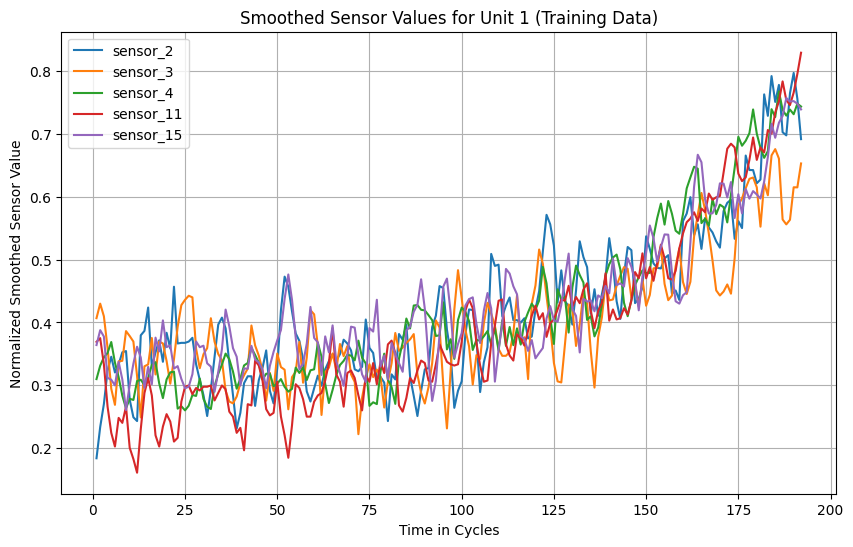

In [12]:
# Step 4: Smooth Noisy Sensors

# Define sensors to smooth (based on high variability and RUL correlation)
noisy_sensors = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_11', 'sensor_15']
print("Sensors to Smooth:", noisy_sensors)

# Function to apply rolling mean smoothing
def smooth_sensors(df, sensor_cols, window=3):
    """
    Apply rolling mean to specified sensors per unit to reduce noise.
    Window size balances noise reduction and trend preservation.
    """
    for col in sensor_cols:
        if col in df.columns:
            df[col] = df.groupby('unit')[col].transform(
                lambda x: x.rolling(window, min_periods=1, center=False).mean()
            )
    return df

# Apply smoothing to training and test data
fd1_train = smooth_sensors(fd1_train, noisy_sensors)
fd1_test = smooth_sensors(fd1_test, noisy_sensors)

# Verify smoothing by checking sample data
print("\nSample Smoothed Training Data (Selected Sensors, First 5 Rows):")
print(fd1_train[noisy_sensors].head())

print("\nSample Smoothed Test Data (Selected Sensors, First 5 Rows):")
print(fd1_test[noisy_sensors].head())

# Check for missing values after smoothing
print("\nMissing Values in Training Features After Smoothing:", fd1_train[feature_cols].isna().sum().sum())
print("Missing Values in Test Features After Smoothing:", fd1_test[feature_cols].isna().sum().sum())

# Optional: Visualize smoothing effect for one unit
unit_data = fd1_train[fd1_train['unit'] == 1]
plt.figure(figsize=(10, 6))
for col in noisy_sensors:
    plt.plot(unit_data['time_in_cycles'], unit_data[col], label=col)
plt.xlabel('Time in Cycles')
plt.ylabel('Normalized Smoothed Sensor Value')
plt.title('Smoothed Sensor Values for Unit 1 (Training Data)')
plt.legend()
plt.grid(True)
plt.show()

Sensors for Feature Engineering: ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_11', 'sensor_12', 'sensor_15']

Updated Feature Columns (Including Rolling Means):
['operational_setting_1', 'operational_setting_2', 'operational_setting_3', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21', 'sensor_2_roll_mean', 'sensor_3_roll_mean', 'sensor_4_roll_mean', 'sensor_7_roll_mean', 'sensor_11_roll_mean', 'sensor_12_roll_mean', 'sensor_15_roll_mean']
Number of Features: 25

Training Feature Range After Feature Engineering and Normalization:
Min Values:
 operational_setting_1    0.0
operational_setting_2    0.0
operational_setting_3    0.0
sensor_2                 0.0
sensor_3                 0.0
sensor_4                 0.0
sensor_6                 0.0
sensor_7                 0.0
sensor_8                 0.0
sensor_9                 0.0
sensor_11  

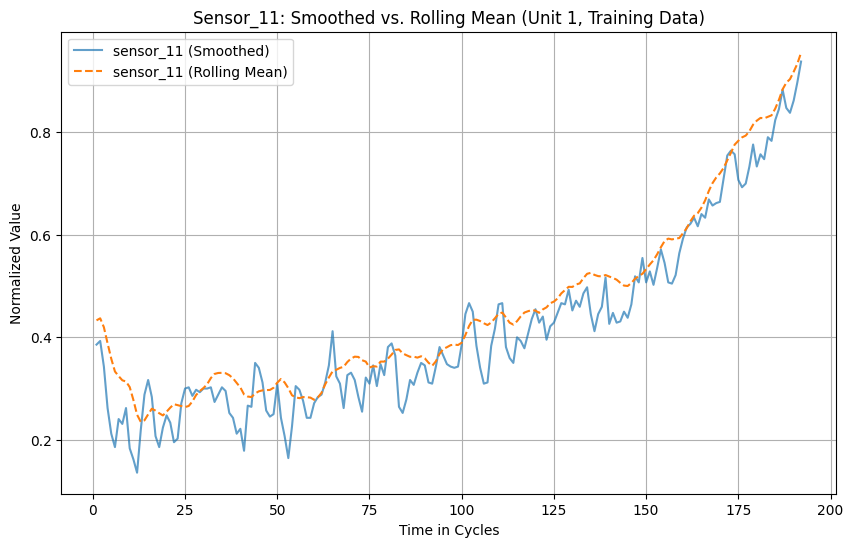

In [13]:
# Step 5: Feature Engineering

# Define key sensors for feature engineering (based on high RUL correlation)
key_sensors = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_11', 'sensor_12', 'sensor_15']
print("Sensors for Feature Engineering:", key_sensors)

# Function to add rolling mean features
def add_features(df, sensor_cols, window=10):
    """
    Add rolling mean features for specified sensors per unit to capture degradation trends.
    Window size of 10 balances long-term trends and responsiveness.
    """
    for col in sensor_cols:
        if col in df.columns:
            df[f'{col}_roll_mean'] = df.groupby('unit')[col].transform(
                lambda x: x.rolling(window, min_periods=1, center=False).mean()
            )
    return df

# Apply feature engineering to training and test data
fd1_train = add_features(fd1_train, key_sensors)
fd1_test = add_features(fd1_test, key_sensors)

# Update feature columns to include new rolling mean features
feature_cols = [col for col in fd1_train.columns if col not in ['unit', 'time_in_cycles', 'RUL']]
print("\nUpdated Feature Columns (Including Rolling Means):")
print(feature_cols)
print("Number of Features:", len(feature_cols))

# Normalize all features (original + new) using MinMaxScaler
scaler = MinMaxScaler()
fd1_train[feature_cols] = scaler.fit_transform(fd1_train[feature_cols])
fd1_test[feature_cols] = scaler.transform(fd1_test[feature_cols])

# Verify normalization of all features
print("\nTraining Feature Range After Feature Engineering and Normalization:")
print("Min Values:\n", fd1_train[feature_cols].min())
print("Max Values:\n", fd1_train[feature_cols].max())

print("\nTest Feature Range After Feature Engineering and Normalization:")
print("Min Values:\n", fd1_test[feature_cols].min())
print("Max Values:\n", fd1_test[feature_cols].max())

# Check for missing values after feature engineering and normalization
print("\nMissing Values in Training Features:", fd1_train[feature_cols].isna().sum().sum())
print("Missing Values in Test Features:", fd1_test[feature_cols].isna().sum().sum())

# Optional: Visualize original vs. rolling mean for one sensor (e.g., sensor_11) for Unit 1
unit_data = fd1_train[fd1_train['unit'] == 1]
plt.figure(figsize=(10, 6))
plt.plot(unit_data['time_in_cycles'], unit_data['sensor_11'], label='sensor_11 (Smoothed)', alpha=0.7)
plt.plot(unit_data['time_in_cycles'], unit_data['sensor_11_roll_mean'], label='sensor_11 (Rolling Mean)', linestyle='--')
plt.xlabel('Time in Cycles')
plt.ylabel('Normalized Value')
plt.title('Sensor_11: Smoothed vs. Rolling Mean (Unit 1, Training Data)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Step 6: Sequence Segmentation

# Function to create sequences
def create_sequences(df, sequence_length, feature_cols, target_col):
    """
    Create fixed-length sequences for each unit, with padding for short sequences.
    Returns 3D array (samples, sequence_length, features) and 1D RUL array.
    """
    X, y = [], []
    for unit in df['unit'].unique():
        unit_data = df[df['unit'] == unit]
        for start in range(0, len(unit_data) - sequence_length + 1, 1):
            end = start + sequence_length
            X.append(unit_data[feature_cols].iloc[start:end].values)
            y.append(unit_data[target_col].iloc[end - 1])
        # Handle last sequence with padding if too short
        if len(unit_data) >= 1:
            seq = unit_data[feature_cols].iloc[-sequence_length:].values
            if len(seq) < sequence_length:
                seq = np.pad(seq, ((sequence_length - len(seq), 0), (0, 0)), mode='edge')
            X.append(seq)
            y.append(unit_data[target_col].iloc[-1])
    return np.array(X), np.array(y)

# Set sequence length
sequence_length = 30

# Create sequences for training and test data
X_train, y_train = create_sequences(fd1_train, sequence_length, feature_cols, 'RUL')
X_test, y_test = create_sequences(fd1_test, sequence_length, feature_cols, 'RUL')

# Verify shapes
print("Training Sequences Shape (X_train):", X_train.shape)
print("Training RUL Shape (y_train):", y_train.shape)
print("Test Sequences Shape (X_test):", X_test.shape)
print("Test RUL Shape (y_test):", y_test.shape)

# Check for missing values in sequences
print("\nMissing Values in X_train:", np.isnan(X_train).sum())
print("Missing Values in y_train:", np.isnan(y_train).sum())
print("Missing Values in X_test:", np.isnan(X_test).sum())
print("Missing Values in y_test:", np.isnan(y_test).sum())

# Verify RUL range
print("\nTraining RUL Range: Min =", y_train.min(), ", Max =", y_train.max())
print("Test RUL Range: Min =", y_test.min(), ", Max =", y_test.max())

Training Sequences Shape (X_train): (17831, 30, 25)
Training RUL Shape (y_train): (17831,)
Test Sequences Shape (X_test): (10296, 30, 25)
Test RUL Shape (y_test): (10296,)

Missing Values in X_train: 0
Missing Values in y_train: 0
Missing Values in X_test: 0
Missing Values in y_test: 0

Training RUL Range: Min = 0 , Max = 130
Test RUL Range: Min = 7 , Max = 130


In [15]:
# Step 7: Train-Test Split for Validation

# Split training sequences into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Verify shapes
print("Training Split Shape (X_train_split):", X_train_split.shape)
print("Validation Shape (X_val):", X_val.shape)
print("Training RUL Split Shape (y_train_split):", y_train_split.shape)
print("Validation RUL Shape (y_val):", y_val.shape)

# Check for missing values
print("\nMissing Values in X_train_split:", np.isnan(X_train_split).sum())
print("Missing Values in X_val:", np.isnan(X_val).sum())
print("Missing Values in y_train_split:", np.isnan(y_train_split).sum())
print("Missing Values in y_val:", np.isnan(y_val).sum())

# Verify RUL distribution
print("\nTraining Split RUL Range: Min =", y_train_split.min(), ", Max =", y_train_split.max())
print("Validation RUL Range: Min =", y_val.min(), ", Max =", y_val.max())

Training Split Shape (X_train_split): (14264, 30, 25)
Validation Shape (X_val): (3567, 30, 25)
Training RUL Split Shape (y_train_split): (14264,)
Validation RUL Shape (y_val): (3567,)

Missing Values in X_train_split: 0
Missing Values in X_val: 0
Missing Values in y_train_split: 0
Missing Values in y_val: 0

Training Split RUL Range: Min = 0 , Max = 130
Validation RUL Range: Min = 0 , Max = 130


Final Data Shapes:
X_train_split: (14264, 30, 25)
y_train_split: (14264,)
X_val: (3567, 30, 25)
y_val: (3567,)
X_test: (10296, 30, 25)
y_test: (10296,)


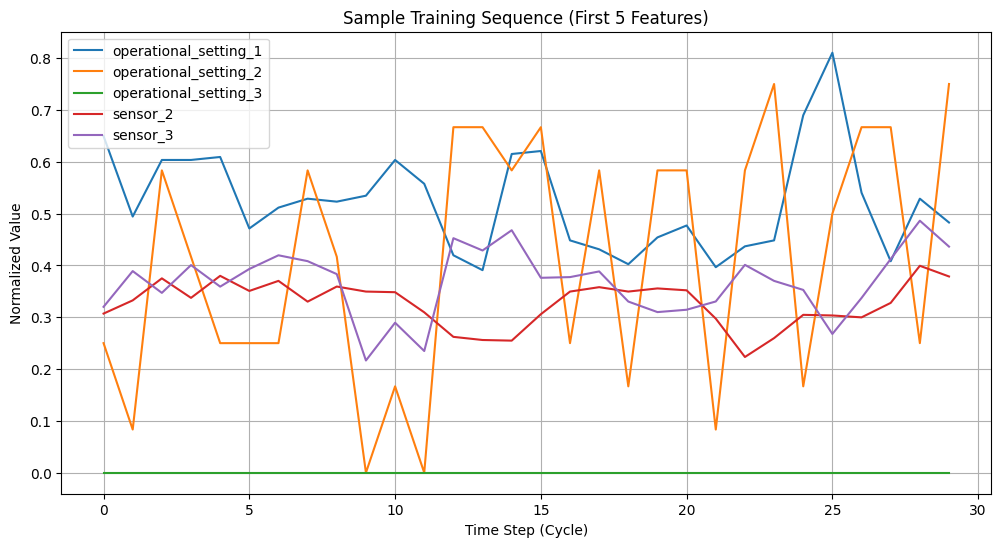

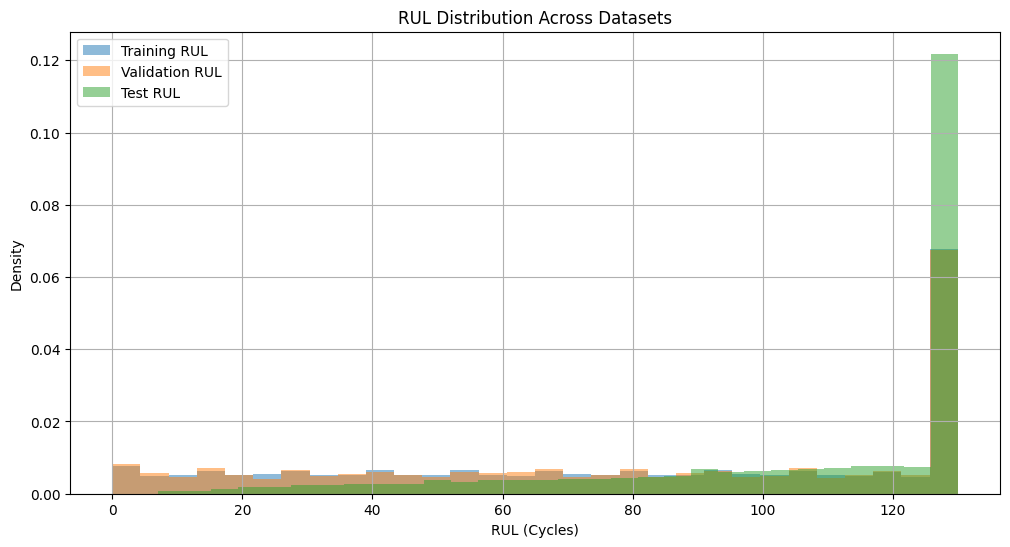


Training Sequence Values Outside [0, 1]:
Min: 0.0 Max: 1.0000000000000002
Validation Sequence Values Outside [0, 1]:
Min: 0.0 Max: 1.0
Test Sequence Values Outside [0, 1]:
Min: -0.08840385318864515 Max: 1.0833333333333335


In [16]:
# Step 8: Verify Data Quality

# Confirm final shapes
print("Final Data Shapes:")
print("X_train_split:", X_train_split.shape)
print("y_train_split:", y_train_split.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

# Visualize first 5 features of a sample sequence (e.g., first sequence in X_train_split)
sample_seq = X_train_split[0]  # Shape: (30, 24)
plt.figure(figsize=(12, 6))
for i in range(min(5, len(feature_cols))):  # Plot first 5 features
    plt.plot(range(sequence_length), sample_seq[:, i], label=feature_cols[i])
plt.xlabel('Time Step (Cycle)')
plt.ylabel('Normalized Value')
plt.title('Sample Training Sequence (First 5 Features)')
plt.legend()
plt.grid(True)
plt.show()

# Plot RUL distribution for training, validation, and test sets
plt.figure(figsize=(12, 6))
plt.hist(y_train_split, bins=30, alpha=0.5, label='Training RUL', density=True)
plt.hist(y_val, bins=30, alpha=0.5, label='Validation RUL', density=True)
plt.hist(y_test, bins=30, alpha=0.5, label='Test RUL', density=True)
plt.xlabel('RUL (Cycles)')
plt.ylabel('Density')
plt.title('RUL Distribution Across Datasets')
plt.legend()
plt.grid(True)
plt.show()

# Check for outliers or anomalies in sequences (e.g., values outside [0, 1])
print("\nTraining Sequence Values Outside [0, 1]:")
print("Min:", X_train_split.min(), "Max:", X_train_split.max())
print("Validation Sequence Values Outside [0, 1]:")
print("Min:", X_val.min(), "Max:", X_val.max())
print("Test Sequence Values Outside [0, 1]:")
print("Min:", X_test.min(), "Max:", X_test.max())

In [17]:
# Fix: Verify and Correct Feature Count
print("Current feature_cols:", feature_cols)
print("Number of Features:", len(feature_cols))

# Expected features (2 settings + 15 sensors + 7 rolling means)
expected_features = [
    'operational_setting_1', 'operational_setting_2',
    'sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9',
    'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21',
    'sensor_2_roll_mean', 'sensor_3_roll_mean', 'sensor_4_roll_mean', 'sensor_7_roll_mean',
    'sensor_11_roll_mean', 'sensor_12_roll_mean', 'sensor_15_roll_mean'
]

# Check for discrepancies
if len(feature_cols) != 24 or set(feature_cols) != set(expected_features):
    print("Feature count mismatch! Resetting to expected features.")
    feature_cols = expected_features
    print("Corrected feature_cols:", feature_cols)
    print("Number of Features:", len(feature_cols))

# Re-run Sequence Segmentation with corrected test logic
def create_sequences(df, sequence_length, feature_cols, target_col, test_mode=False):
    """
    Create sequences for training (all windows) or test (last sequence per unit).
    Test_mode=True limits to one sequence per unit (last 30 cycles).
    """
    X, y = [], []
    for unit in df['unit'].unique():
        unit_data = df[df['unit'] == unit]
        if test_mode:
            # Take last sequence (pad if needed)
            seq = unit_data[feature_cols].iloc[-sequence_length:].values
            if len(seq) < sequence_length:
                seq = np.pad(seq, ((sequence_length - len(seq), 0), (0, 0)), mode='edge')
            X.append(seq)
            y.append(unit_data[target_col].iloc[-1])
        else:
            # Training: all possible sequences
            for start in range(0, len(unit_data) - sequence_length + 1, 1):
                end = start + sequence_length
                X.append(unit_data[feature_cols].iloc[start:end].values)
                y.append(unit_data[target_col].iloc[end - 1])
            # Include last sequence
            if len(unit_data) >= 1:
                seq = unit_data[feature_cols].iloc[-sequence_length:].values
                if len(seq) < sequence_length:
                    seq = np.pad(seq, ((sequence_length - len(seq), 0), (0, 0)), mode='edge')
                X.append(seq)
                y.append(unit_data[target_col].iloc[-1])
    return np.array(X), np.array(y)

# Set sequence length
sequence_length = 30

# Create sequences
X_train, y_train = create_sequences(fd1_train, sequence_length, feature_cols, 'RUL', test_mode=False)
X_test, y_test = create_sequences(fd1_test, sequence_length, feature_cols, 'RUL', test_mode=True)

# Split training data
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Verify shapes and data quality
print("\nCorrected Data Shapes:")
print("X_train_split:", X_train_split.shape)
print("y_train_split:", y_train_split.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

print("\nMissing Values:")
print("X_train_split:", np.isnan(X_train_split).sum())
print("X_val:", np.isnan(X_val).sum())
print("X_test:", np.isnan(X_test).sum())
print("y_train_split:", np.isnan(y_train_split).sum())
print("y_val:", np.isnan(y_val).sum())
print("y_test:", np.isnan(y_test).sum())

print("\nRUL Ranges:")
print("Training Split:", y_train_split.min(), y_train_split.max())
print("Validation:", y_val.min(), y_val.max())
print("Test:", y_test.min(), y_test.max())

print("\nSequence Values:")
print("Training Split: Min =", X_train_split.min(), "Max =", X_train_split.max())
print("Validation: Min =", X_val.min(), "Max =", X_val.max())
print("Test: Min =", X_test.min(), "Max =", X_test.max())

Current feature_cols: ['operational_setting_1', 'operational_setting_2', 'operational_setting_3', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21', 'sensor_2_roll_mean', 'sensor_3_roll_mean', 'sensor_4_roll_mean', 'sensor_7_roll_mean', 'sensor_11_roll_mean', 'sensor_12_roll_mean', 'sensor_15_roll_mean']
Number of Features: 25
Feature count mismatch! Resetting to expected features.
Corrected feature_cols: ['operational_setting_1', 'operational_setting_2', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21', 'sensor_2_roll_mean', 'sensor_3_roll_mean', 'sensor_4_roll_mean', 'sensor_7_roll_mean', 'sensor_11_roll_mean', 'sensor_12_roll_mean', 'sensor_15_roll_mean']
Number of Features: 24

Corrected Data Shapes:
X_train_spl

In [18]:
# Step 9: Model Training (CNN-LSTM with Attention)

# Define Attention Layer (from your old model)
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        e = tf.matmul(inputs, self.W) + self.b
        e = tf.tanh(e)
        e = tf.squeeze(e, axis=-1)
        alpha = tf.nn.softmax(e, axis=-1)
        alpha = tf.expand_dims(alpha, axis=-1)
        context = inputs * alpha
        context = tf.reduce_sum(context, axis=1)
        return context

# Build CNN-LSTM model
def build_cnn_lstm_attention(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        LSTM(100, return_sequences=True),
        Dropout(0.3),
        LSTM(50, return_sequences=True),
        Dropout(0.3),
        AttentionLayer(),
        Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Define input shape
input_shape = (sequence_length, len(feature_cols))





In [19]:
# Build model
model = build_cnn_lstm_attention(input_shape)
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

callbacks = [early_stopping, lr_scheduler, checkpoint]

# Train model
history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 15, 100)        │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 15, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 50)             │            65 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,610 (603.95 KB)

 Trainable params: 154,226 (602.45 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 5853.3252 - mae: 64.0392 - val_loss: 1468.6024 - val_mae: 30.0813 - learning_rate: 5.0000e-04
Epoch 2/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 489.3596 - mae: 17.1673 - val_loss: 627.0528 - val_mae: 19.3150 - learning_rate: 5.0000e-04
Epoch 3/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 393.3250 - mae: 15.0194 - val_loss: 252.0221 - val_mae: 12.0229 - learning_rate: 5.0000e-04
Epoch 4/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 367.2288 - mae: 14.4321 - val_loss: 450.4396 - val_mae: 16.3123 - learning_rate: 5.0000e-04
Epoch 5/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 338.1605 - mae: 13.7480 - val_loss: 411.7519 - val_mae: 15.5431 - learning_rate: 5.0000e-04
Epoch 6/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 310.4434 - mae: 13.2803 - val_loss: 315.7661 - val_mae: 12.2362 - learning_rate: 5.0000e-04
Epoch 7/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 277.775

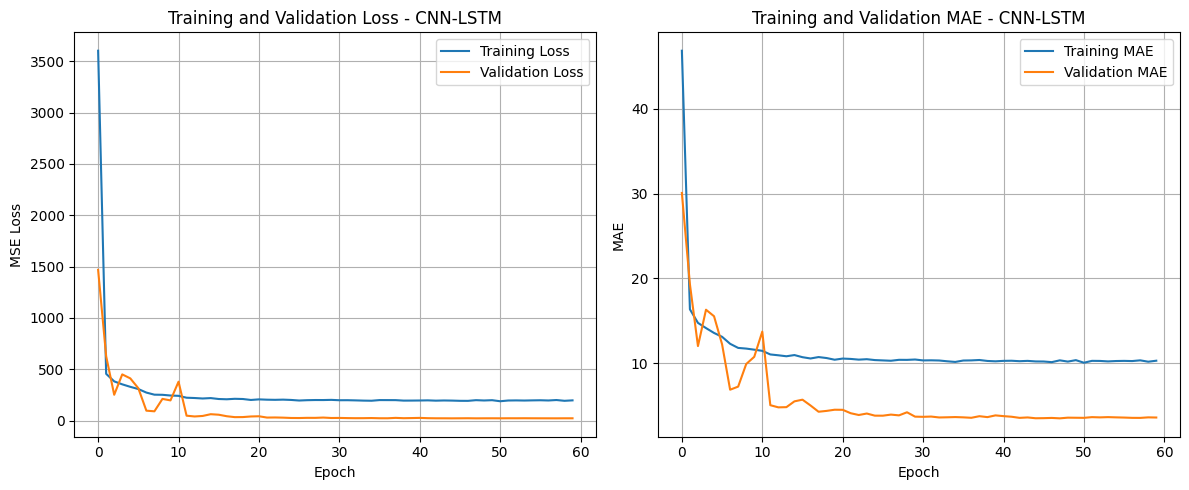


Test Metrics:
Test Loss (MSE): 259.3624
Test MAE: 11.7109
Test RMSE: 16.0721
Test R2 Score: 0.8440
Test MAPE: 18.92%


In [29]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - CNN-LSTM')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE - CNN-LSTM')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test, verbose=0).flatten()

# Compute metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("\nTest Metrics:")
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R2 Score: {test_r2:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")

Selected Sensors for Correlation Heatmap: ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']


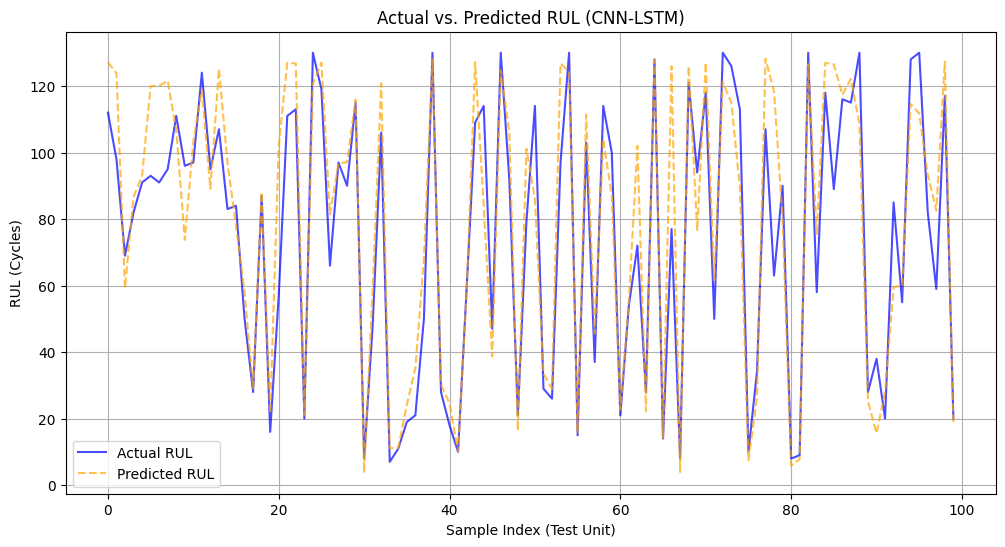

In [23]:
# Additional Visualizations for Model Interpretation

# Ensure required imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define selected sensors for correlation heatmap
selected_sensors = [col for col in feature_cols if col.startswith('sensor') and not col.endswith('roll_mean')]
print("Selected Sensors for Correlation Heatmap:", selected_sensors)

# 1. Actual vs. Predicted RUL (Time-Series)
plt.figure(figsize=(12, 6))
indices = np.arange(len(y_test))
plt.plot(indices, y_test, label='Actual RUL', color='blue', alpha=0.7)
plt.plot(indices, y_pred, label='Predicted RUL', color='orange', alpha=0.7, linestyle='--')
plt.xlabel('Sample Index (Test Unit)')
plt.ylabel('RUL (Cycles)')
plt.title('Actual vs. Predicted RUL (CNN-LSTM)')
plt.legend()
plt.grid(True)
plt.show()

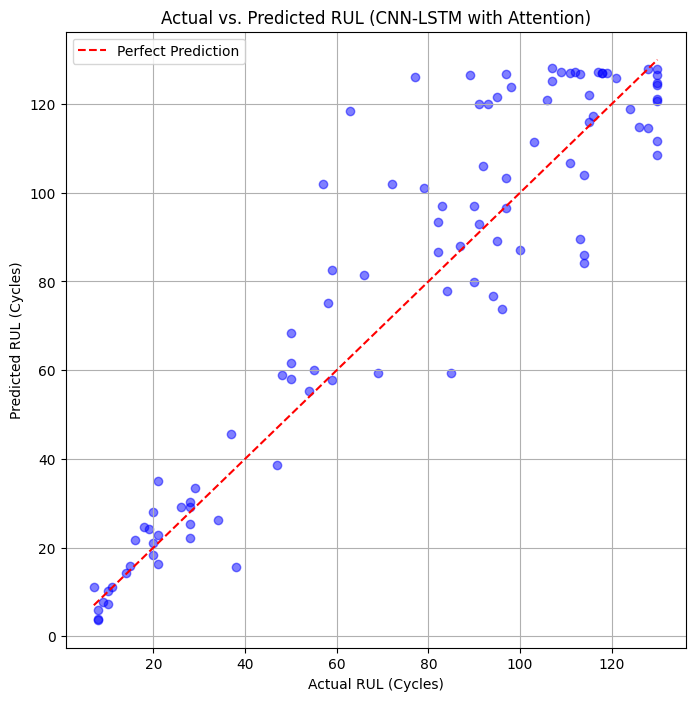

In [24]:
# 2. Actual vs. Predicted RUL (Scatter)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual RUL (Cycles)')
plt.ylabel('Predicted RUL (Cycles)')
plt.title('Actual vs. Predicted RUL (CNN-LSTM with Attention)')
plt.legend()
plt.grid(True)
plt.show()


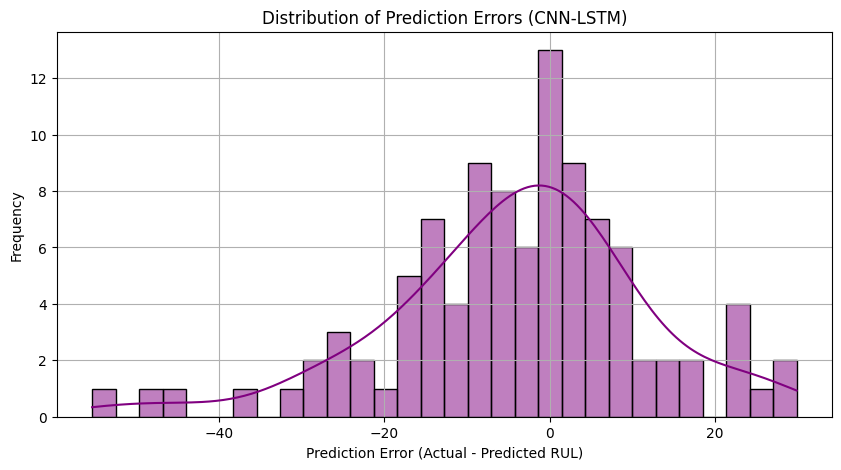

In [25]:
# 3. Prediction Error Distribution
errors = y_test - y_pred
plt.figure(figsize=(10, 5))
sns.histplot(errors, bins=30, kde=True, color='purple')
plt.xlabel('Prediction Error (Actual - Predicted RUL)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors (CNN-LSTM)')
plt.grid(True)
plt.show()

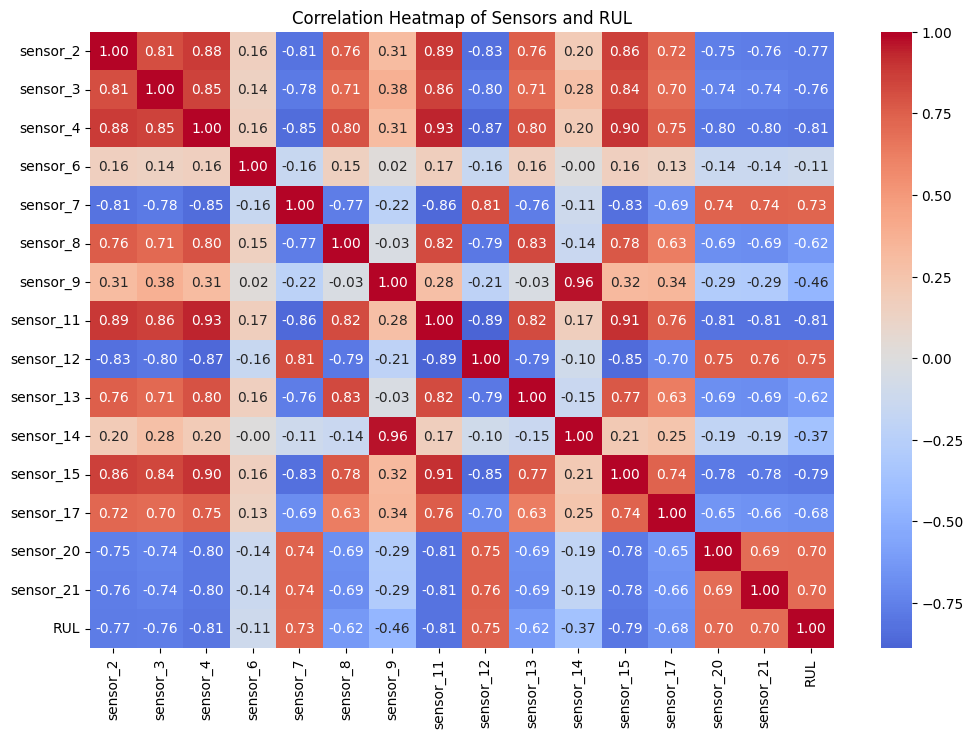

In [26]:
# 4. Correlation Heatmap of Sensors with RUL
plt.figure(figsize=(12, 8))
corr_matrix = fd1_train[selected_sensors + ['RUL']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap of Sensors and RUL')
plt.show()

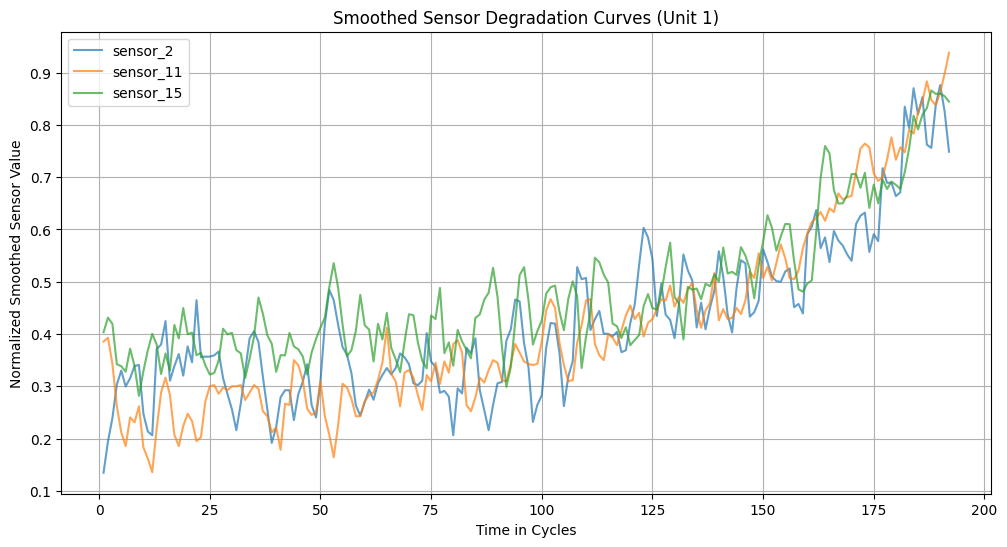

In [27]:
# 5. Smoothed Degradation Curves for Unit 1
unit_data = fd1_train[fd1_train['unit'] == 1]
plt.figure(figsize=(12, 6))
for col in ['sensor_2', 'sensor_11', 'sensor_15']:
    plt.plot(unit_data['time_in_cycles'], unit_data[col], label=col, alpha=0.7)
plt.xlabel('Time in Cycles')
plt.ylabel('Normalized Smoothed Sensor Value')
plt.title('Smoothed Sensor Degradation Curves (Unit 1)')
plt.legend()
plt.grid(True)
plt.show()

### BILSTM

In [31]:
# Step 10: Train BiLSTM Model with Attention

# Ensure required imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, BatchNormalization, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import tensorflow as tf

# Define Attention Layer (reused from CNN-LSTM)
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        e = tf.matmul(inputs, self.W) + self.b
        e = tf.tanh(e)
        e = tf.squeeze(e, axis=-1)
        alpha = tf.nn.softmax(e, axis=-1)
        alpha = tf.expand_dims(alpha, axis=-1)
        context = inputs * alpha
        context = tf.reduce_sum(context, axis=1)
        return context

# Build BiLSTM model with attention
def build_bilstm_attention(input_shape):
    model = Sequential([
        # First BiLSTM layer
        Bidirectional(LSTM(100, return_sequences=True), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        # Second BiLSTM layer
        Bidirectional(LSTM(50, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.3),
        # Attention layer
        AttentionLayer(),
        # Dense layers
        Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Define input shape
sequence_length = 30
input_shape = (sequence_length, len(feature_cols))

# Build model
bilstm_model = build_bilstm_attention(input_shape)
bilstm_model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_bilstm_model.keras', monitor='val_loss', save_best_only=True)

callbacks = [early_stopping, lr_scheduler, checkpoint]

# Train model
history = bilstm_model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 200)        │       100,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 200)        │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 30, 100)        │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_1               │ (None, 100)            │           130 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,831 (807.93 KB)

 Trainable params: 206,231 (805.59 KB)

 Non-trainable params: 600 (2.34 KB)

Epoch 1/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 4034.8164 - mae: 49.8276 - val_loss: 256.9159 - val_mae: 12.7551 - learning_rate: 5.0000e-04
Epoch 2/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 434.6291 - mae: 15.7610 - val_loss: 662.6668 - val_mae: 18.6587 - learning_rate: 5.0000e-04
Epoch 3/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 386.4287 - mae: 14.8786 - val_loss: 377.0108 - val_mae: 13.6653 - learning_rate: 5.0000e-04
Epoch 4/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 366.1214 - mae: 14.3609 - val_loss: 2185.9353 - val_mae: 38.6212 - learning_rate: 5.0000e-04
Epoch 5/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 324.5559 - mae: 13.4102 - val_loss: 559.0595 - val_mae: 17.2069 - learning_rate: 2.5000e-04
Epoch 6/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 321.4173 - mae: 13.3351 - val_loss: 196.1559 - val_mae: 9.6596 - learning_rate: 2.5000e-04
Epoch 7/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 307.7101

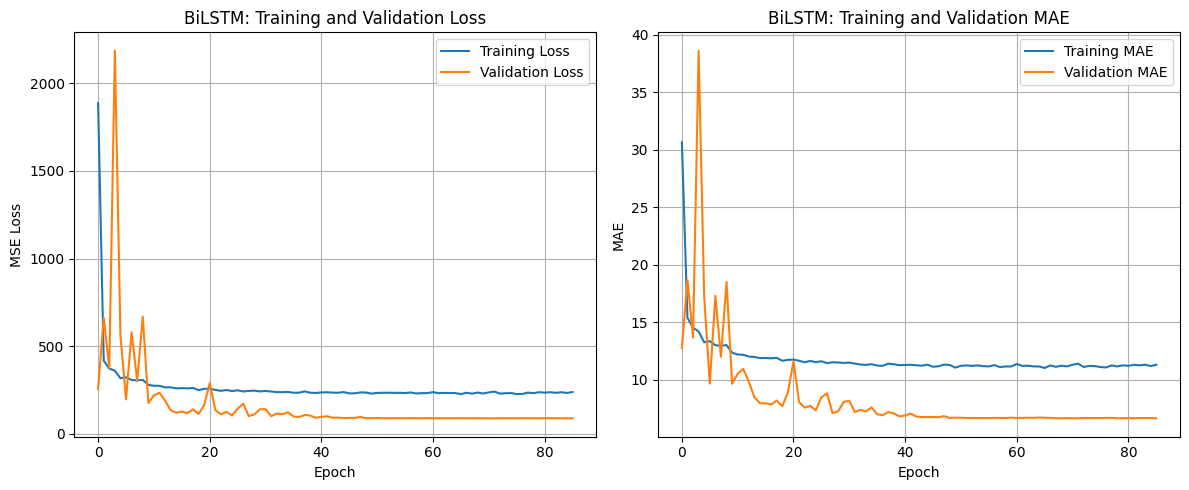


BiLSTM Test Metrics:
Test Loss (MSE): 283.6804
Test MAE: 12.3183
Test RMSE: 16.8150
Test R2 Score: 0.8292
Test MAPE: 18.04%


In [32]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('BiLSTM: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('BiLSTM: Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate model
test_loss, test_mae = bilstm_model.evaluate(X_test, y_test, verbose=0)
y_pred = bilstm_model.predict(X_test, verbose=0).flatten()

# Compute metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("\nBiLSTM Test Metrics:")
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R2 Score: {test_r2:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")




Selected Sensors for Correlation Heatmap: ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']


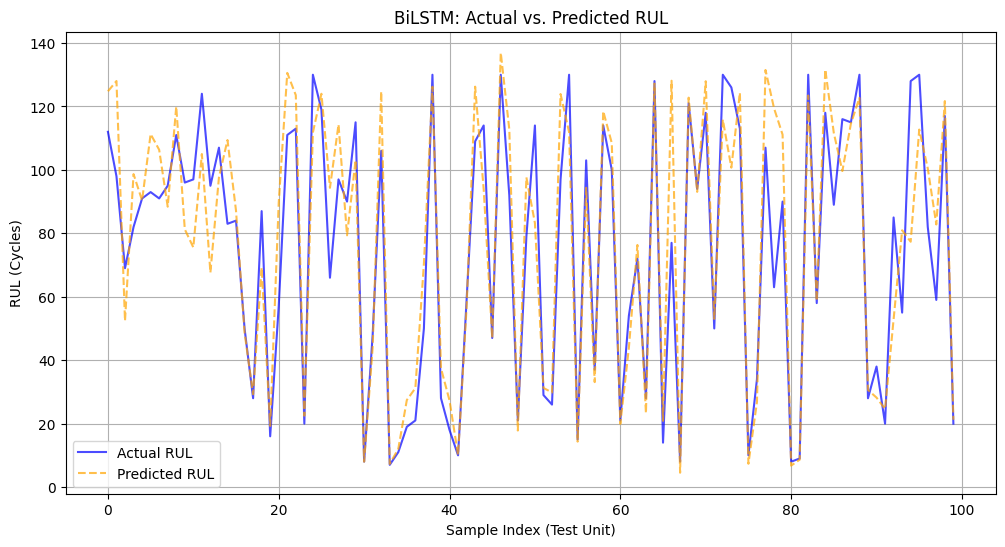

In [33]:
# Visualizations
# Define selected sensors for correlation heatmap
selected_sensors = [col for col in feature_cols if col.startswith('sensor') and not col.endswith('roll_mean')]
print("\nSelected Sensors for Correlation Heatmap:", selected_sensors)

# 1. Actual vs. Predicted RUL (Time-Series)
plt.figure(figsize=(12, 6))
indices = np.arange(len(y_test))
plt.plot(indices, y_test, label='Actual RUL', color='blue', alpha=0.7)
plt.plot(indices, y_pred, label='Predicted RUL', color='orange', alpha=0.7, linestyle='--')
plt.xlabel('Sample Index (Test Unit)')
plt.ylabel('RUL (Cycles)')
plt.title('BiLSTM: Actual vs. Predicted RUL')
plt.legend()
plt.grid(True)
plt.show()


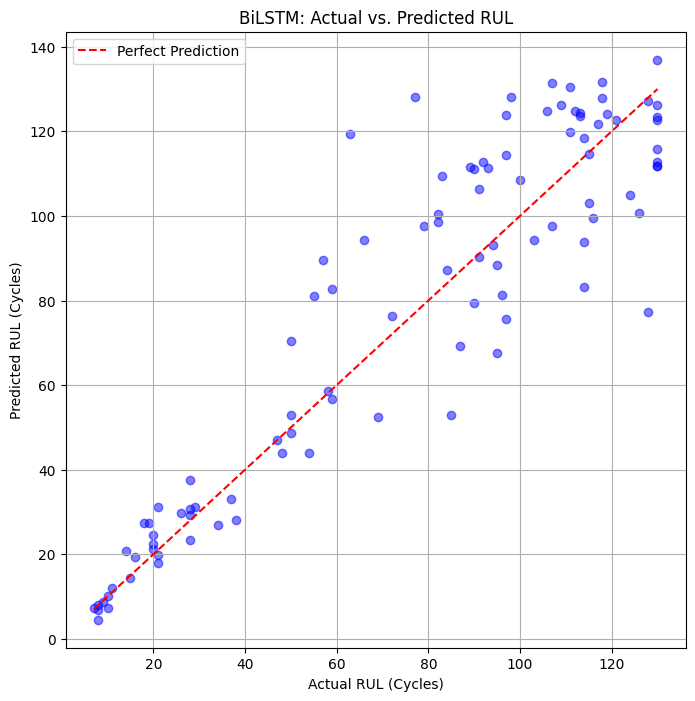

In [34]:
# 2. Actual vs. Predicted RUL (Scatter)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual RUL (Cycles)')
plt.ylabel('Predicted RUL (Cycles)')
plt.title('BiLSTM: Actual vs. Predicted RUL')
plt.legend()
plt.grid(True)
plt.show()

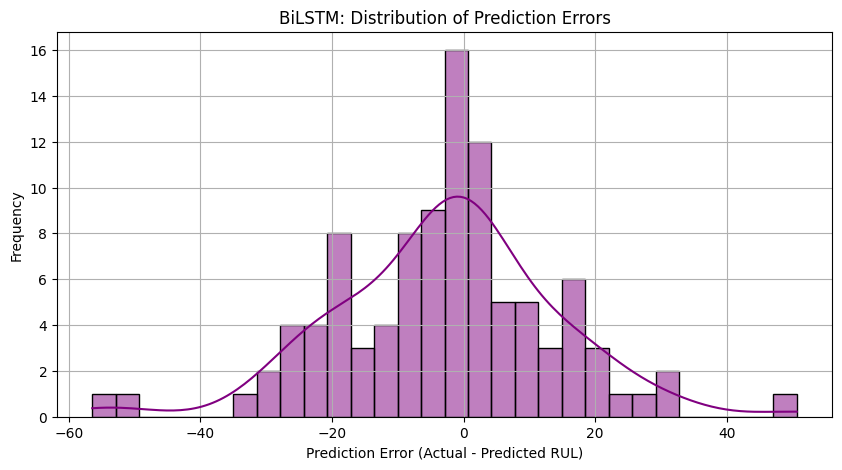

In [35]:
# 3. Prediction Error Distribution
errors = y_test - y_pred
plt.figure(figsize=(10, 5))
sns.histplot(errors, bins=30, kde=True, color='purple')
plt.xlabel('Prediction Error (Actual - Predicted RUL)')
plt.ylabel('Frequency')
plt.title('BiLSTM: Distribution of Prediction Errors')
plt.grid(True)
plt.show()

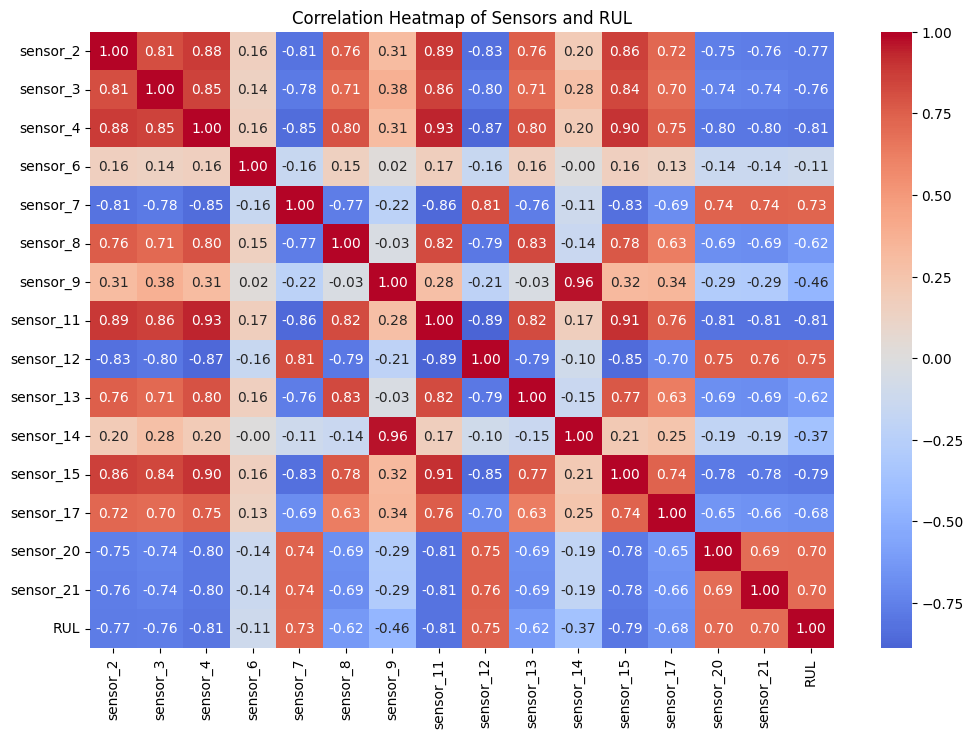

In [36]:
# 4. Correlation Heatmap of Sensors with RUL
plt.figure(figsize=(12, 8))
corr_matrix = fd1_train[selected_sensors + ['RUL']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap of Sensors and RUL')
plt.show()

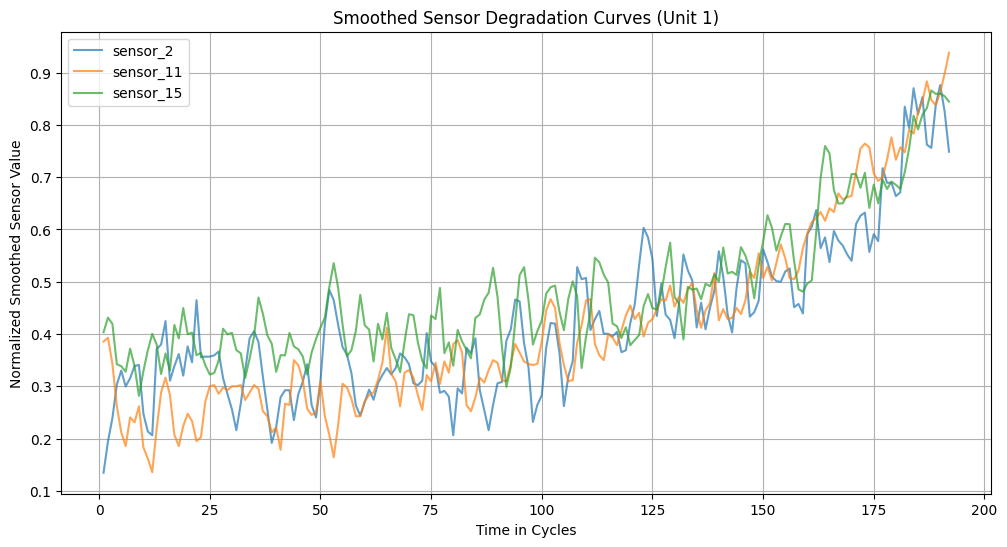

In [37]:
# 5. Smoothed Degradation Curves for Unit 1
unit_data = fd1_train[fd1_train['unit'] == 1]
plt.figure(figsize=(12, 6))
for col in ['sensor_2', 'sensor_11', 'sensor_15']:
    plt.plot(unit_data['time_in_cycles'], unit_data[col], label=col, alpha=0.7)
plt.xlabel('Time in Cycles')
plt.ylabel('Normalized Smoothed Sensor Value')
plt.title('Smoothed Sensor Degradation Curves (Unit 1)')
plt.legend()
plt.grid(True)
plt.show()

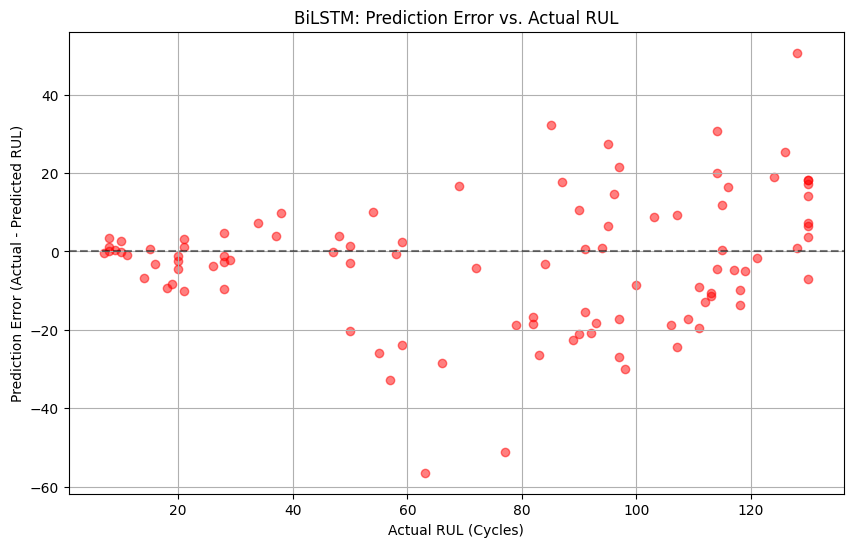

In [41]:
# 7. RUL Prediction Error vs. Actual RUL
plt.figure(figsize=(10, 6))
plt.scatter(y_test, errors, alpha=0.5, color='red')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Actual RUL (Cycles)')
plt.ylabel('Prediction Error (Actual - Predicted RUL)')
plt.title('BiLSTM: Prediction Error vs. Actual RUL')
plt.grid(True)
plt.show()